p     MSE_fixed MSE_sure  FDR_fixed FDR_sure  FP_fixed  FP_sure   TPR_fixed TPR_sure  lam_fixed lam_sure  
0.90  1.0637    0.2857    0.0011    0.6905    0.1600    532.0967  0.5174    0.8380    3.9843    1.2424    
0.91  0.9618    0.2666    0.0013    0.7014    0.1717    506.1433  0.5169    0.8323    3.9843    1.2793    
0.92  0.8593    0.2465    0.0015    0.7136    0.1717    475.8067  0.5178    0.8291    3.9843    1.3178    
0.93  0.7490    0.2237    0.0022    0.7244    0.2233    438.0800  0.5167    0.8231    3.9843    1.3702    
0.94  0.6398    0.1996    0.0023    0.7320    0.1967    386.0467  0.5162    0.8134    3.9843    1.4441    
0.95  0.5361    0.1755    0.0022    0.7481    0.1600    350.1933  0.5183    0.8033    3.9843    1.5015    
0.96  0.4265    0.1482    0.0033    0.7647    0.1867    305.0067  0.5187    0.7957    3.9843    1.5778    
0.97  0.3191    0.1186    0.0037    0.7788    0.1617    250.6317  0.5184    0.7826    3.9843    1.6797    
0.98  0.2156    0.0884    0.0067    0

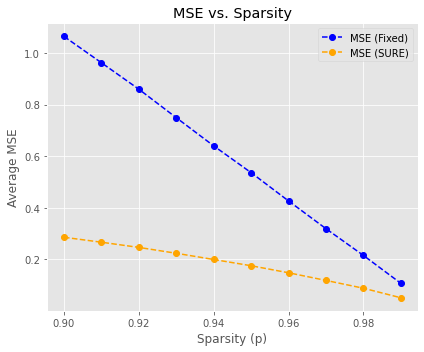

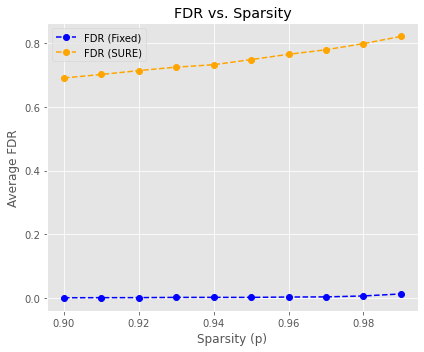

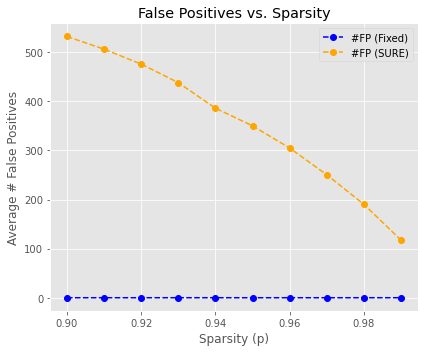

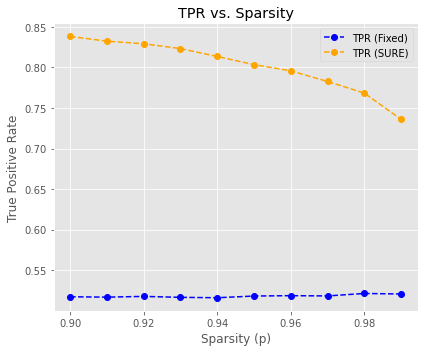

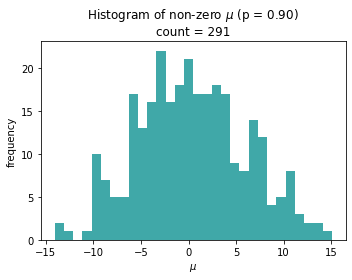

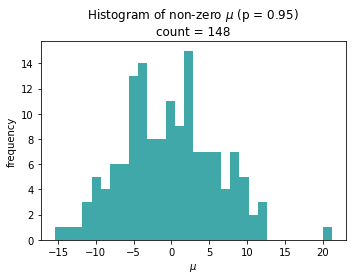

In [1]:
import numpy as np
import matplotlib.pyplot as plt

z = np.loadtxt('police.txt')

def soft_threshold(z, t):
    return np.sign(z) * np.maximum(np.abs(z) - t, 0.0)

def sure_soft_threshold(z, t, sigma=1.0):
    z_hat = soft_threshold(z, t)
    rss = np.sum((z_hat - z) ** 2)
    df = np.sum(np.abs(z) > t)
    return (rss + 2 * sigma**2 * df) / len(z)

def find_best_threshold_sure(z, sigma=1.0):
    absz = np.abs(z)
    uniq = np.unique(absz)
    best_t, best_s = 0.0, float('inf')
    for t in uniq:
        s = sure_soft_threshold(z, t, sigma)
        if s < best_s:
            best_s, best_t = s, t
    return best_t, best_s

def measure_fp_tpr(X, threshold, mu_true):
    discover = np.abs(X) > threshold
    fp = ((mu_true == 0) & discover).sum()
    tp = ((mu_true != 0) & discover).sum()
    positives = (mu_true != 0).sum()
    tpr = 0.0 if positives == 0 else tp / positives
    return fp, tpr

def compute_fdr(X, threshold, mu_true):
    discover = np.abs(X) > threshold
    R = discover.sum()
    if R == 0:
        return 0.0
    V = ((mu_true == 0) & discover).sum()
    return V / R


def run_single_experiment(n, sigma, p, mu_nonzero_mean, mu_nonzero_std):
    #generate true nonzero means from normal distribution with study motivated std
    is_zero = np.random.rand(n) < p
    mu_true = np.zeros(n)
    mu_true[~is_zero] = np.random.normal(mu_nonzero_mean, mu_nonzero_std, (~is_zero).sum())

    #true signals, true nonzero + noise
    X = mu_true + np.random.normal(0, sigma, n)

    lam_fixed = np.sqrt(2 * np.log(n))
    Xhat_fixed = soft_threshold(X, lam_fixed)
    mse_fixed = np.mean((Xhat_fixed - mu_true) ** 2)
    fdr_fixed = compute_fdr(X, lam_fixed, mu_true)
    fp_fixed, tpr_fixed = measure_fp_tpr(X, lam_fixed, mu_true)

    lam_sure, _ = find_best_threshold_sure(X, sigma)
    Xhat_sure = soft_threshold(X, lam_sure)
    mse_sure = np.mean((Xhat_sure - mu_true) ** 2)
    fdr_sure = compute_fdr(X, lam_sure, mu_true)
    fp_sure, tpr_sure = measure_fp_tpr(X, lam_sure, mu_true)
    
    #for table and plotting
    return (mse_fixed, mse_sure, fdr_fixed, fdr_sure, lam_fixed, lam_sure,
            fp_fixed, fp_sure, tpr_fixed, tpr_sure)

def run_simulation(n=2000, sigma=1.0, p=0.5, mu_nonzero_mean=0.0, mu_nonzero_std=1.0,
                   n_repeats=1000):
    mse_f=[]; mse_s=[]
    fdr_f=[]; fdr_s=[]
    lam_f=[]; lam_s=[]
    fp_f=[]; fp_s=[]
    tpr_f=[]; tpr_s=[]
    for _ in range(n_repeats):
        (mf, ms, ff, fs, lf, ls,
         fpf, fps, tpf, tps) = run_single_experiment(n, sigma, p, mu_nonzero_mean, mu_nonzero_std)
        mse_f.append(mf); mse_s.append(ms)
        fdr_f.append(ff); fdr_s.append(fs)
        lam_f.append(lf); lam_s.append(ls)
        fp_f.append(fpf); fp_s.append(fps)
        tpr_f.append(tpf); tpr_s.append(tps)
    return {
        'mse_fixed': np.mean(mse_f), 'mse_sure': np.mean(mse_s),'fdr_fixed': np.mean(fdr_f), 'fdr_sure': np.mean(fdr_s),
        'lam_fixed': np.mean(lam_f), 'lam_sure': np.mean(lam_s),'fp_fixed': np.mean(fp_f), 'fp_sure': np.mean(fp_s),
        'tpr_fixed': np.mean(tpr_f), 'tpr_sure': np.mean(tpr_s),}

p_values = np.arange(0.90, 1.00, 0.01)
n = 2800
sigma = 1.0
mu_nonzero_mean = 0.0
mu_nonzero_std = 6.08
n_repeats = 600

mse_fixed_vals=[]; mse_sure_vals=[]
fdr_fixed_vals=[]; fdr_sure_vals=[]
fp_fixed_vals=[]; fp_sure_vals=[]
tpr_fixed_vals=[]; tpr_sure_vals=[]

print(f"{'p':<6}{'MSE_fixed':<10}{'MSE_sure':<10}"
      f"{'FDR_fixed':<10}{'FDR_sure':<10}"
      f"{'FP_fixed':<10}{'FP_sure':<10}"
      f"{'TPR_fixed':<10}{'TPR_sure':<10}"
      f"{'lam_fixed':<10}{'lam_sure':<10}")

lam_sure_vals = []
for p in p_values:
    out = run_simulation(n=n, sigma=sigma, p=p,
                         mu_nonzero_mean=mu_nonzero_mean,
                         mu_nonzero_std=mu_nonzero_std,
                         n_repeats=n_repeats)
    mse_fixed_vals.append(out['mse_fixed'])
    mse_sure_vals.append(out['mse_sure'])
    fdr_fixed_vals.append(out['fdr_fixed'])
    fdr_sure_vals.append(out['fdr_sure'])
    fp_fixed_vals.append(out['fp_fixed'])
    fp_sure_vals.append(out['fp_sure'])
    tpr_fixed_vals.append(out['tpr_fixed'])
    tpr_sure_vals.append(out['tpr_sure'])
    
    lam_sure_vals.append(out['lam_sure'])

    print(f"{p:<6.2f}{out['mse_fixed']:<10.4f}{out['mse_sure']:<10.4f}"
          f"{out['fdr_fixed']:<10.4f}{out['fdr_sure']:<10.4f}"
          f"{out['fp_fixed']:<10.4f}{out['fp_sure']:<10.4f}"
          f"{out['tpr_fixed']:<10.4f}{out['tpr_sure']:<10.4f}"
          f"{out['lam_fixed']:<10.4f}{out['lam_sure']:<10.4f}")

#nicer ggplot graphs
import matplotlib as mpl
with plt.style.context('ggplot'):

    plt.figure(figsize=(6,5))
    plt.plot(p_values, mse_fixed_vals, 'o--', label='MSE (Fixed)', color='blue')
    plt.plot(p_values, mse_sure_vals, 'o--', label='MSE (SURE)', color='orange')
    plt.xlabel('Sparsity (p)'); plt.ylabel('Average MSE')
    plt.title('MSE vs. Sparsity'); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(p_values, fdr_fixed_vals, 'o--', label='FDR (Fixed)', color='blue')
    plt.plot(p_values, fdr_sure_vals, 'o--', label='FDR (SURE)', color='orange')
    plt.xlabel('Sparsity (p)'); plt.ylabel('Average FDR')
    plt.title('FDR vs. Sparsity'); plt.legend(); plt.tight_layout(); plt.show()
    
    plt.figure(figsize=(6,5))
    plt.plot(p_values, fp_fixed_vals, 'o--', label='#FP (Fixed)', color='blue')
    plt.plot(p_values, fp_sure_vals, 'o--', label='#FP (SURE)', color='orange')
    plt.xlabel('Sparsity (p)'); plt.ylabel('Average # False Positives')
    plt.title('False Positives vs. Sparsity'); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(p_values, tpr_fixed_vals, 'o--', label='TPR (Fixed)', color='blue')
    plt.plot(p_values, tpr_sure_vals, 'o--', label='TPR (SURE)', color='orange')
    plt.xlabel('Sparsity (p)'); plt.ylabel('True Positive Rate')
    plt.title('TPR vs. Sparsity'); plt.legend(); plt.tight_layout(); plt.show()

def draw_histogram(n, sigma, p, mu_mean, mu_std, seed=None):
    if seed is not None:
        np.random.seed(seed)
    is_zero = np.random.rand(n) < p
    mu_true = np.zeros(n)
    mu_true[~is_zero] = np.random.normal(mu_mean, mu_std, (~is_zero).sum())
    not_zero = mu_true[mu_true != 0]

    plt.figure(figsize=(5,4))
    if not_zero.size > 0:
        plt.hist(not_zero, bins=30, color='darkcyan', alpha=0.75)
        plt.title(f'Histogram of non-zero $\mu$ (p = {p:.2f})\ncount = {not_zero.size}')
    else:
        plt.text(0.5, 0.5, 'No non-zeros in this replicate', ha='center', va='center')
        plt.title(f'Histogram of non-zero $\mu$ (p = {p:.2f})')
    plt.xlabel('$\mu$'); plt.ylabel('frequency')
    plt.tight_layout(); plt.show()

#to see distribution of nonzero mu 
draw_histogram(n, sigma, 0.90, mu_nonzero_mean, mu_nonzero_std, seed=None)
draw_histogram(n, sigma, 0.95, mu_nonzero_mean, mu_nonzero_std, seed=None)


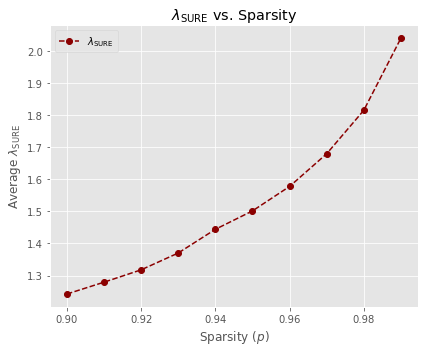

In [2]:
plt.style.use('ggplot')        
plt.figure(figsize=(6, 5))
plt.plot(p_values, lam_sure_vals, 'o--', color='darkred', label=r'$\lambda_{\mathrm{SURE}}$')
plt.xlabel('Sparsity ($p$)')
plt.ylabel(r'Average $\lambda_{\mathrm{SURE}}$')
plt.title(r'$\lambda_{\mathrm{SURE}}$ vs. Sparsity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()